# In this project, my goal is to write a software pipeline to identify the lane boundaries and detect vehicle in a video from a front-facing camera on a car

In [30]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import pickle
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline  

nx = 9 #the number of inside Chessboard corners in x
ny = 6 #the number of inside Chessboard corners in y
cal_path = './camera_cal/calibration*.jpg'

img_width = 1280
img_height = 720

#Hardcode source 4 points to warp
src_left_bottom = [200, 720]
src_left_top = [595, 450]
src_right_top = [685, 450]
src_right_bottom = [1100, 720]

#Hardcode destination 4 points on warped image
dst_left_bottom = [300, 720]
dst_left_top = [300, 0]
dst_right_top = [980, 0]
dst_right_bottom = [980, 720]

#Diff between left and right curveture in metres
diff_curv_margin = 200
#Diff between top and bottom curveture distance in metres
diff_top_bottom_margin = 0.5

output_video_path = './lane_and_vehicle_detected_out2.mp4'
path_to_clip = "./project_video.mp4"

## Setup part:

In [12]:
#Camera calibration
#objpoints, imgpoints  = camera_calibration()
# points_dictionary = {"objpoints": objpoints, "imgpoints": imgpoints}
# pickle.dump(points_dictionary, open( "wide_dist_pickle.p", "wb" ))

#Setup chessboards params 
dist_pickle = pickle.load( open( "wide_dist_pickle.p", "rb" ) )
objpoints = dist_pickle["objpoints"]
imgpoints = dist_pickle["imgpoints"]

#Setup camera params
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, (img_height, img_width), None, None)

#Setup warp params
src = np.float32([src_left_bottom, src_left_top, src_right_top, src_right_bottom])
dst = np.float32([dst_left_bottom, dst_left_top, dst_right_top, dst_right_bottom])
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)

#Setup plot params
# Define conversions in x and y from pixels space to meters
ploty = np.linspace(0, img_height-1, img_height )
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/680 # meters per pixel in x dimension
y_eval = np.max(ploty)

## Definitions of all used functions:

In [21]:
def camera_calibration():
    # prepare object points
    objpoints = [] #3D points in real world space
    imgpoints = [] #2D point in image space

    # Make a list of calibration images
    images = glob.glob(cal_path)

    #Prepare object points
    objp = np.zeros((ny*nx,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)  # x, y coordinates

    for fname in images:

        img = mpimg.imread(fname)
        # Convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

        # # If found, draw corners
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
    
    return objpoints, imgpoints

def cal_undistort(img, objpoints, imgpoints):
    undistorted = cv2.undistort(img, mtx, dist, None, mtx)
    return undistorted

def sobel_thresh(img, sobel_type='x', sobel_kernel=3, sobel_thresh=(0,255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    # 2) Take the derivative in x or y given orient = 'x' or 'y' or 'xy' or 'yx' or 'dir' for gradient direction
    # 3) Take the absolute value of the derivative or gradient
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8. For gradient direction take arctang.
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    # 6) Return this mask as your binary_output image
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F,1,0, ksize= sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F,0,1, ksize= sobel_kernel)
    
    if (sobel_type == 'x'):     
        absolute = np.absolute(sobelx)
    elif (sobel_type == 'y'):       
        absolute = np.absolute(sobely)
    elif ((sobel_type == 'xy') | (sobel_type == 'yx')):
        absolute = np.sqrt(np.square(sobelx) + np.square(sobely))
        
    if (sobel_type == 'dir'):
        scaled = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    else:
        scaled = np.uint8(255*absolute/np.max(absolute))
        
    binary_output = np.zeros_like(scaled)
    binary_output[(scaled > sobel_thresh[0]) & (scaled < sobel_thresh[1])] = 1
    return binary_output

def warp_img(undistorted, inverse=False):
    img_size = (img_width, img_height)
    
    if (inverse):
        warped = cv2.warpPerspective(undistorted, Minv, img_size)
    else:
        warped = cv2.warpPerspective(undistorted, M, img_size)
        
    return warped

def combined_threshold(image, thresh=(100,255)):
    #image should be undistorted
    R_channel = image[:,:,0]
    R_binary = np.zeros_like(R_channel)
    R_binary[(R_channel > thresh[0]) & (R_channel <= thresh[1])] = 1
    
    HLS = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    S_channel = HLS[:,:,2]
    S_binary = np.zeros_like(S_channel)
    S_binary[(S_channel > thresh[0]) & (S_channel <= thresh[1])] = 1

    gradx = sobel_thresh(image, sobel_type='x', sobel_kernel=5, sobel_thresh=(thresh[0], thresh[1]))
    grady = sobel_thresh(image, sobel_type='y', sobel_kernel=5, sobel_thresh=(thresh[0], thresh[1]))
    mag_binary = sobel_thresh(image, sobel_type='xy', sobel_kernel=9, sobel_thresh=(thresh[0], thresh[1]))
    dir_binary = sobel_thresh(image, sobel_type='dir', sobel_kernel=15, sobel_thresh=(0.7, 1.3))
    
    combined = np.zeros_like(dir_binary)
    combined[(((gradx == 1) | (grady == 1)) & (mag_binary == 1) | ((S_binary == 1) & (R_binary == 1))) & (dir_binary == 1)] = 1
    return combined


def sliding_window(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    #out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    out_img = np.zeros_like(binary_warped)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
##    Visualisation part, for debugging and writeup only. Normally commented
#     ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
#     left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
#     right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

#     out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
#     out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
#     plt.imshow(out_img)
#     plt.plot(left_fitx, ploty, color='yellow')
#     plt.plot(right_fitx, ploty, color='yellow')
#     plt.xlim(0, 1280)
#     plt.ylim(720, 0)
    
    return left_fit, right_fit

def already_detected(binary_warped, left_fit, right_fit):
    # Assume you we have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    return left_fit, right_fit

def plot_lane_surface(image, left_fit, right_fit, label_str_curv, label_str_offset):
    window_img = np.zeros_like(image)

    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    right_line_window = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    line_pts = np.hstack((left_line_window, right_line_window))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([line_pts]), (0,255, 0))

    newwarp = warp_img(window_img, inverse=True)
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)

    result = cv2.putText(result, label_str_curv, (30,40), 0, 1, (0,0,0), 2, cv2.LINE_AA)
    result = cv2.putText(result, label_str_offset, (30,70), 0, 1, (0,0,0), 2, cv2.LINE_AA)
    
    return result

def measure_curvature_and_offset(left_fit, right_fit):
    # Fit new polynomials to x,y in world space
    leftx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    rightx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    
    # Annotate lane curvature values and vehicle offset from center
    avg_curve = (left_curverad + right_curverad)/2
    vehicle_offset = ((leftx[-1] + rightx[-1])//2 - img_width//2) * xm_per_pix
    diff_top_bottom = abs((rightx[0] - leftx[0]) - (rightx[-1] - leftx[-1])) * xm_per_pix
    diff_curv = abs(left_curverad - right_curverad)
    bad_detected_flag = (diff_top_bottom > diff_top_bottom_margin) | (diff_curv > diff_curv_margin)
    
    label_str_curv = 'Radius of curvature: %.1f m.' % avg_curve
    label_str_offset = 'Vehicle offset from lane center: %.1f m.' % vehicle_offset
    return label_str_curv, label_str_offset, bad_detected_flag

## Class of line. Decide if we calculate sliding window from scratch or use previous one, then plot the average of 5 last polynomial coefficients:

In [14]:
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        #counter for the bad detection. If counter == 3 then we recalculate sliding window
        self.bad_detected_count = 0  
        self.bad_detected_flag = False  
        #polynomial coefficients for the most recent left fit
        self.current_left_fit = None
        #polynomial coefficients for the most recent right fit
        self.current_right_fit = None
        #history of polynomial coefficients for the left fit
        self.left_fit = []
        #history of polynomial coefficients for the right fit
        self.right_fit = []
        #counter for calculate curvature. We measure every tenth frame
        self.counter = 0
        #curvature measure string
        self.label_str_curv = None
        #offset measure string
        self.label_str_offset = None
        #history of box_list
        self.box_list = []
        
    def detect_lines_and_vehicles(self, video):
        clip1 = VideoFileClip(path_to_clip)
        lane_plotted_clip = clip1.fl_image(self.process_image) #NOTE: this function expects color images!!
        %time lane_plotted_clip.write_videofile(output_video_path, audio=False)
    
    def process_image(self, img):
        self.counter += 1
        image = cal_undistort(img, objpoints, imgpoints)
        combined = combined_threshold(image)
        binary_warped = warp_img(combined)
        
        if (self.bad_detected_count == 3):
            self.detected = False
            self.bad_detected_count = 0
        
        if (((self.counter % 10) == 0) & self.detected):
            self.label_str_curv, self.label_str_offset, self.bad_detected_flag = measure_curvature_and_offset(self.current_left_fit, self.current_right_fit)          
            if (self.bad_detected_flag):
                self.bad_detected_count += 1
            else:
                self.bad_detected_count = 0
                
        if (self.detected):
            self.current_left_fit, self.current_right_fit = already_detected(binary_warped, self.current_left_fit, self.current_right_fit)
            self.left_fit.append(self.current_left_fit)
            self.right_fit.append(self.current_right_fit)
        else:
            self.bad_detected_count = 0
            self.current_left_fit, self.current_right_fit  = sliding_window(binary_warped)
            self.label_str_curv, self.label_str_offset, self.bad_detected_flag = measure_curvature_and_offset(self.current_left_fit, self.current_right_fit)
            self.detected = True
            if (self.bad_detected_flag):
                self.bad_detected_count += 1
            self.left_fit.append(self.current_left_fit)
            self.right_fit.append(self.current_right_fit)   
            
        #plot average of 5 last polynomial coefficients
        result_lines = plot_lane_surface(img, np.mean(self.left_fit[-5:], axis=0), np.mean(self.right_fit[-5:], axis=0), self.label_str_curv, self.label_str_offset)
        box_list = find_cars(result_lines, ystart, ystop, scale, cells_per_step, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
        self.box_list.append(box_list)
        final_result = detect_vehicles(result_lines, self.box_list[-10:])
        return final_result     

# Part of vehicle detecting

In [33]:
import matplotlib.image as mpimg
import numpy as np
import cv2
from skimage.feature import hog
import glob
import math
from scipy.ndimage.measurements import label

orient = 9
pix_per_cell = 8
cell_per_block = 2
spatial_size=(32, 32)
hist_bins = 32
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"

ystart = 400
ystop = 656
scale = np.array([1.0, 1.5]).astype(float)
cells_per_step = 2

heat_threshold = 12

# svc, X_scaler = train_classifier(colorspace = 'YCrCb')
# dist_pickle = {"svc": svc, "X_scaler": X_scaler}
# pickle.dump(dist_pickle, open( "svc_scaler_pickle.p", "wb" ))

#Setup SCV par and X_scaler
dist_pickle = pickle.load( open( "svc_scaler_pickle.p", "rb" ) )
svc = dist_pickle["svc"]
X_scaler = dist_pickle["X_scaler"]

In [16]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))
                        
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features



# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features
    

def train_classifier(colorspace):

    notcars = glob.glob('non-vehicles/*')
    cars = glob.glob('vehicles/*/*')
    
    t=time.time()
    car_features = extract_features(cars, color_space=colorspace, orient=orient, 
                            pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                            hog_channel=hog_channel)
    notcar_features = extract_features(notcars, color_space=colorspace, orient=orient, 
                            pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                            hog_channel=hog_channel)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to extract HOG features...')
    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)

    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
        scaled_X, y, test_size=0.2, random_state=rand_state)

    print('Using:',orient,'orientations',pix_per_cell,
        'pixels per cell and', cell_per_block,'cells per block')
    print('Feature vector length:', len(X_train[0]))
    # Use a linear SVC 
    svc = LinearSVC()
    # Check the training time for the SVC
    t=time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to train SVC...')
    # Check the score of the SVC
    print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
    # Check the prediction time for a single sample
    t=time.time()
    n_predict = 10
    print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
    print('For these',n_predict, 'labels: ', y_test[0:n_predict])
    t2 = time.time()
    print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')
    return svc, X_scaler

In [17]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale_list, cps, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    
    
    for scale in scale_list:
        ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
        if scale != 1:
            imshape = ctrans_tosearch.shape
            ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]

        # Define blocks and steps as above
        nxblocks = math.ceil(ch1.shape[1] / pix_per_cell) - cell_per_block + 1
        nyblocks = math.ceil(ch1.shape[0] / pix_per_cell) - cell_per_block + 1 
        nfeat_per_block = orient*cell_per_block**2

        # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
        window = 64
        nblocks_per_window = math.ceil(window / pix_per_cell) - cell_per_block + 1  
        cells_per_step = cps  # Instead of overlap, define how many cells to step
        nxsteps = math.ceil((nxblocks - nblocks_per_window) / cells_per_step)
        nysteps = math.ceil((nyblocks - nblocks_per_window) / cells_per_step)

        # Compute individual channel HOG features for the entire image
        hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)

        box_list = []

        for xb in range(nxsteps):
            for yb in range(nysteps):
                ypos = yb*cells_per_step
                xpos = xb*cells_per_step
                # Extract HOG for this patch
                hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

                xleft = xpos*pix_per_cell
                ytop = ypos*pix_per_cell

                # Extract the image patch
                subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))

                # Get color features
                spatial_features = bin_spatial(subimg, size=spatial_size)
                hist_features = color_hist(subimg, nbins=hist_bins)

                # Scale features and make a prediction
                test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
                #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
                test_prediction = svc.predict(test_features)

                if test_prediction == 1:
                    xbox_left = np.int(xleft*scale)
                    ytop_draw = np.int(ytop*scale)
                    win_draw = np.int(window*scale)
                    box = ((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart))
                    box_list.append(box)
                
    return box_list

In [18]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,255,0), 4)
    # Return the image
    return img

In [19]:
def detect_vehicles(image, box_list):
    # Add heat to each box in box list
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    
    #box_list is in 2D as I measure last 5 frames, encapsulated is 1D from one frame
    for encapuslated in box_list:
        heat = add_heat(heat,encapuslated)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,heat_threshold)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)

#     fig = plt.figure()
#     plt.subplot(121)
#     plt.imshow(draw_img)
#     plt.title('Car Positions')
#     plt.subplot(122)
#     plt.imshow(heatmap, cmap='hot')
#     plt.title('Heat Map')
#     fig.tight_layout()
    return draw_img

# Start detecting lane and vehicles:

In [34]:
line = Line()
line.detect_lines_and_vehicles(path_to_clip)

[MoviePy] >>>> Building video ./lane_and_vehicle_detected_out2.mp4
[MoviePy] Writing video ./lane_and_vehicle_detected_out2.mp4



100%|█████████▉| 1260/1261 [33:51<00:01,  1.74s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./lane_and_vehicle_detected_out2.mp4 

CPU times: user 1h 1min 47s, sys: 3min 3s, total: 1h 4min 50s
Wall time: 33min 52s


## Some example images 

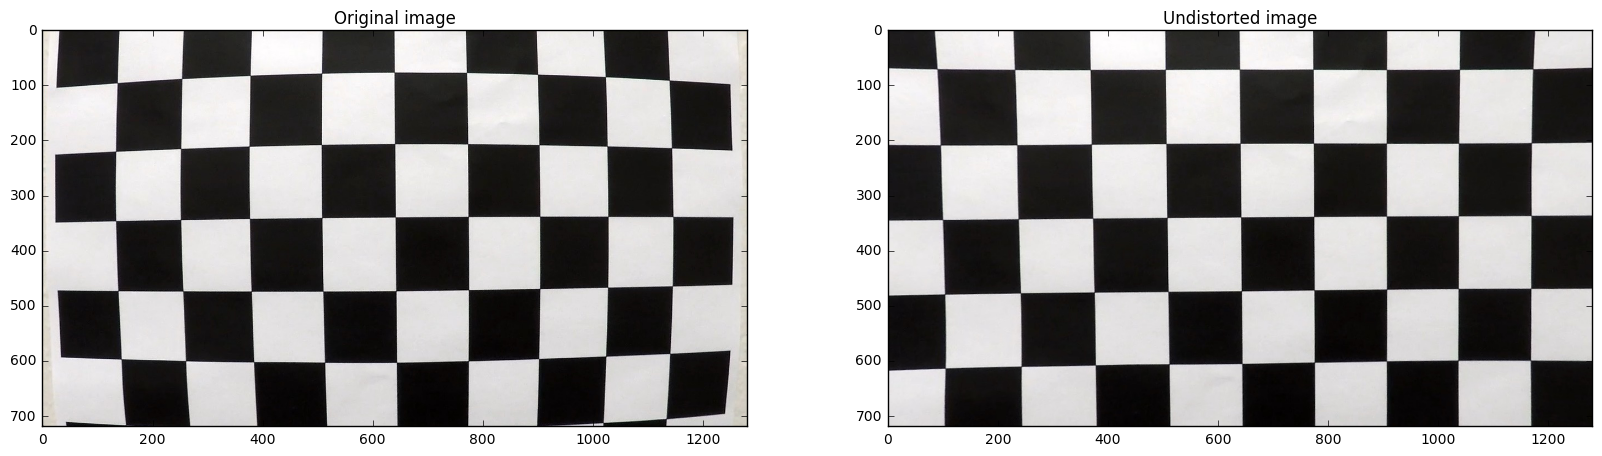

In [78]:
image = mpimg.imread('./camera_cal/calibration1.jpg')

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Original image')
ax1.imshow(image)
ax2.set_title('Undistorted image')
ax2.imshow(cal_undistort(image, objpoints, imgpoints))

f.savefig('./writeup_img/undistorted.png')

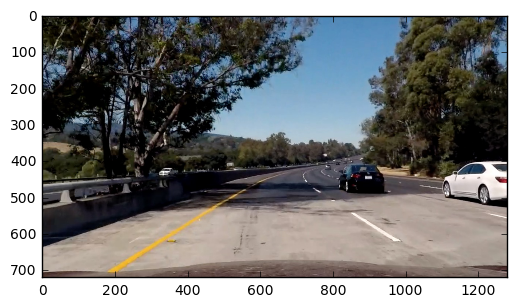

In [99]:
image = mpimg.imread('./test_images/test5.jpg')
plt.imshow(cal_undistort(image, objpoints, imgpoints))
plt.savefig('writeup_img/test5_undistorted.png')

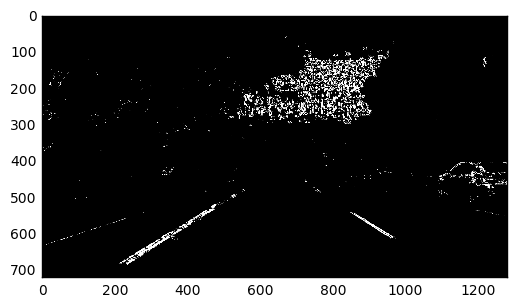

In [98]:
image = mpimg.imread('./test_images/test5.jpg')
combined = combined_threshold(image)
plt.imshow(combined, cmap='gray')
plt.savefig('writeup_img/test5_combined_threshold.png')

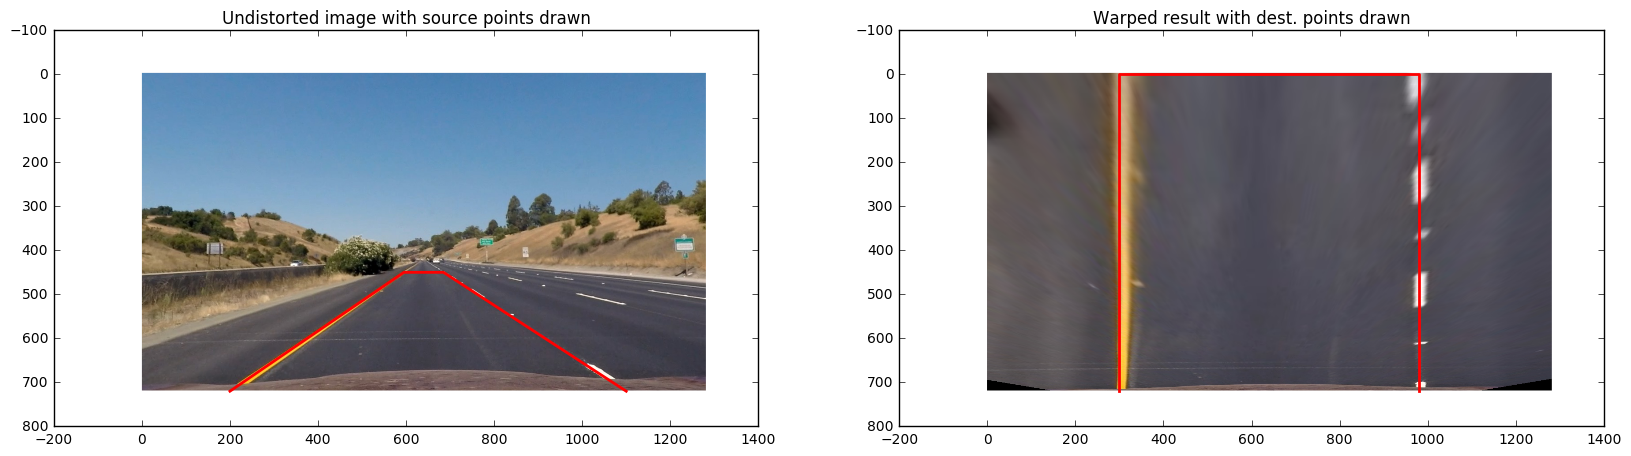

In [106]:
import matplotlib.patches as patches
image = mpimg.imread('./test_images/straight_lines1.jpg')
undistorted = cal_undistort(image, objpoints, imgpoints)

x = [src_left_bottom[0], src_left_top[0], src_right_top[0], src_right_bottom[0]]
y = [src_left_bottom[1], src_left_top[1], src_right_top[1], src_right_bottom[1]]

x1 = [dst_left_bottom[0], dst_left_top[0], dst_right_top[0], dst_right_bottom[0]]
y1 = [dst_left_bottom[1], dst_left_top[1], dst_right_top[1], dst_right_bottom[1]]

warped = warp_img(undistorted)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Undistorted image with source points drawn')
ax1.imshow(undistorted)
ax1.plot(x, y, 'r-', lw=2)
ax2.set_title('Warped result with dest. points drawn')
ax2.imshow(warped)
ax2.plot(x1, y1, 'r-', lw=2)

f.savefig('./writeup_img/src_dst_points_drawn.png')

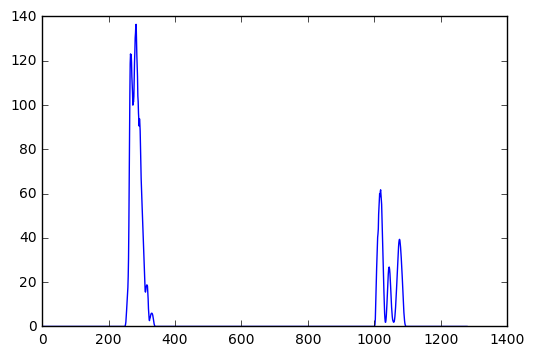

In [110]:
img = mpimg.imread('./test_images/test5.jpg')
image = cal_undistort(img, objpoints, imgpoints)
combined = combined_threshold(image)
binary_warped = warp_img(combined)

histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
plt.plot(histogram)
f.savefig('./writeup_img/histogram.png')

Your function returned a count of 8792  cars and 8967  non-cars
of size:  (64, 64, 3)  and data type: float32


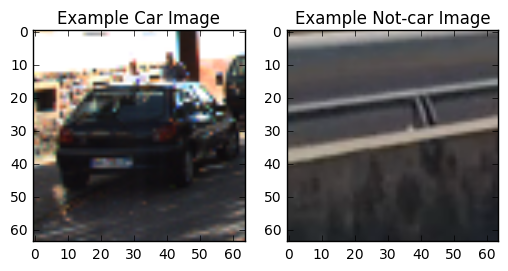

In [74]:
# Define a function to return some characteristics of the dataset 
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(cars)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcars)
    # Read in a test image, either car or notcar
    # Define a key "image_shape" and store the test image shape 3-tuple
    example_img = mpimg.imread(car_list[0])
    data_dict["image_shape"] = example_img.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = example_img.dtype
    # Return data_dict
    return data_dict
    
data_info = data_look(cars, notcars)

print('Your function returned a count of', 
      data_info["n_cars"], ' cars and', 
      data_info["n_notcars"], ' non-cars')
print('of size: ',data_info["image_shape"], ' and data type:', 
      data_info["data_type"])
# Just for fun choose random car / not-car indices and plot example images   
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))
    
# Read in car / not-car images
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])


# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Example Not-car Image')


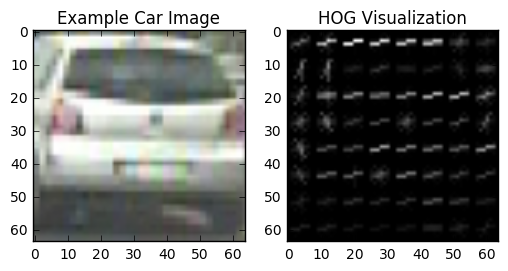

In [75]:
from skimage.feature import hog

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        # Use skimage.hog() to get both features and a visualization
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block), visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    else:      
        # Use skimage.hog() to get features only
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block), visualise=vis, feature_vector=feature_vec)
        return features

# Generate a random index to look at a car image
ind = np.random.randint(0, len(cars))
# Read in the image
image = mpimg.imread(cars[ind])
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2
# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)


# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(image, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')